In [1]:
import numpy as np
import pandas as pd
import subprocess
import re
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

Now we'll generate a list of samples to use as evaluation samples. For this, we'll need to obtain 4 genets from Florida, 1 from Curacao, and 1 from Mexico, and see how close the WGS genotypes are to the genotypes imputed from microarray data. We also want to test this on admixed individuals from Florida (which we removed from the panel), so we'll do a split of 2 individuals from the panel (these will be dropped from the panel) and 2 from the admixed group.

In [2]:
galmet = pd.read_csv("../galaxy_metadata.txt", sep = "\t")

In [3]:
samples = pd.read_csv("~/scratch/refpanel_samplelist.txt", header = None, names = ["Novogene_ID"])
metadata = pd.read_csv("../2024_01_12_PsuData_fixed.csv")
samples = samples.merge(metadata[["Novogene_ID",  "region"]], how = "left", on = "Novogene_ID")
struct = pd.read_csv("~/scratch/ngsadmix_k3_1.qopt", sep = " ", header = None)
struct = pd.concat([samples,struct], axis = 1)
struct = struct.round(5)

In [87]:
struct[struct["region"] == "Florida"][struct[2] < 0.7][struct[2] > 0.4]

/tmp/ipykernel_2402471/3098232388.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  struct[struct["region"] == "Florida"][struct[2] < 0.7][struct[2] > 0.4]


,Novogene_ID,region,0,1,2,3
29,A22118,Florida,0.13263,0.28378,0.58360,NaN
33,A22125,Florida,0.00000,0.58689,0.41311,NaN
52,A22166,Florida,0.00000,0.42430,0.57570,NaN
58,A22234,Florida,0.00000,0.48532,0.51468,NaN


In [93]:
fl_admixed_eval = (galmet[galmet["Coral Mlg Clonal ID"]
                          .isin(metadata["Best Galaxy Match Clonal ID"]
                        [metadata["Novogene_ID"].isin(["A22118", "A22125"])].tolist())].drop_duplicates("Coral Mlg Clonal ID"))

In [95]:
struct[struct["region"] == "Florida"][struct[2] > 0.9].head(1)

/tmp/ipykernel_2402471/3973611126.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  struct[struct["region"] == "Florida"][struct[2] > 0.9].head(1)


,Novogene_ID,region,0,1,2,3
4,A22054,Florida,0.0,0.0,1.0,NaN


In [96]:
struct[struct["region"] == "Florida"][struct[1] > 0.9].head(1)

/tmp/ipykernel_2402471/3250508346.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  struct[struct["region"] == "Florida"][struct[1] > 0.9].head(1)


,Novogene_ID,region,0,1,2,3
6,A22064,Florida,0.0,1.0,0.0,NaN


In [4]:
galmet = pd.read_csv("../galaxy_metadata.txt", sep = "\t")

In [73]:
%%bash
source ~/.bashrc
conda activate beagle
bcftools query -l ../calls/all.phased.tagged.bcf > ../panelsample.txt

In [5]:
panelsamples = pd.read_csv("../panelsample.txt", header = None, names = ["#IID"])

In [6]:
metadata = pd.read_csv("../filtered_DARPA_metadata_fixed.csv")
metadata.columns = ['Questionable?', 'Huck_Sub_ID', 'DNA Plate Well', 'Notes',
       'SampleProviderTubeID', 'FixedTubeID', '#IID', 'Galaxy Name',
       'Best Galaxy Match User ID', 'Coral Mlg Clonal ID',
       'Best Galaxy Match Clonal ID', 'Original Collection Site',
       'Best Galaxy Match Reef Name', 'Best Galaxy Match KING Coefficient',
       'ED50', 'Nursery', 'CBASS_DATE', 'CBASS_POS', 'DNA Plate', 'ng/ul',
       'Instrument', 'Genet', 'Latitude', 'Longitude', 'Region',
       'SampleProvider', 'Spawning', 'Notes.1', 'Additional Notes', 'SeqType',
       'Best Galaxy Match', 'Database ID']

In [7]:
galmet = (galmet[galmet["Affymetrix ID"].isin(metadata["Best Galaxy Match"]
                                              [metadata["#IID"].isin(panelsamples["#IID"].tolist())].tolist())]
                                             [galmet['Genetic Coral Species Call'] == "A.palmata"])

/tmp/ipykernel_2621044/830388769.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  galmet = (galmet[galmet["Affymetrix ID"].isin(metadata["Best Galaxy Match"]


In [101]:
fl_panel_eval = (galmet[galmet["Coral Mlg Clonal ID"]
                          .isin(metadata["Best Galaxy Match Clonal ID"]
                        [metadata["#IID"].isin(["A22054", "A22064"])].tolist())])

In [103]:
cu_eval = (galmet[galmet["Region"].str.contains("Curacao")]).sample(1)

In [104]:
mx_eval = (galmet[galmet["Region"].str.contains("Mexico")]).sample(1)

In [108]:
evalsamples = pd.concat([fl_panel_eval, fl_admixed_eval, cu_eval, mx_eval])

In [112]:
(metadata[["Best Galaxy Match Clonal ID"]][metadata["Best Galaxy Match Clonal ID"]
                    .isin(evalsamples["Coral Mlg Clonal ID"])]
                    .set_index("Best Galaxy Match Clonal ID").to_csv("../evalsamples_mlg.txt", header = None))

In [113]:
(metadata[["#IID"]][metadata["Best Galaxy Match Clonal ID"]
                    .isin(evalsamples["Coral Mlg Clonal ID"])]
                    .set_index("#IID").to_csv("../evalsamples_IDs.txt", header = None))

In [114]:
(evalsamples[["Affymetrix ID"]].set_index("Affymetrix ID").to_csv("../evalsamples_snpchipnames.txt", header = None))

In [24]:
tmp = pd.read_csv("../updated_metadata_rich_with_clonal_id.csv")

In [76]:
%%bash
source ~/.bashrc
conda activate ipyrad
bcftools view ../calls/all.phased.tagged.bcf -H | cut -f1-2 \
    > ../calls/panel_positions.tsv

ERROR: This cross-compiler package contains no program /storage/group/ibb3/default/.conda/envs/ipyrad/bin/x86_64-conda_cos6-linux-gnu-cc
ERROR: activate-gcc_linux-64.sh failed, see above for details


In [77]:
!wc -l ../calls/panel_positions.tsv

2343144 ../calls/panel_positions.tsv


In [78]:
%%bash
source ~/.bashrc
conda activate beagle
rm ../calls/eval_panel.vcf.gz.tbi
bcftools view --samples-file ^../evalsamples_IDs.txt --force-samples \
    ../calls/all.phased.tagged.bcf --min-ac 3:minor \
    -e 'COUNT(GT="AA")=N_SAMPLES || COUNT(GT="RR")=N_SAMPLES' \
    | bcftools annotate --remove "INFO" \
    | bcftools +fill-tags -- -t all \
    | bcftools view -O z  > ../calls/eval_panel.vcf.gz
tabix ../calls/eval_panel.vcf.gz

rm ../calls/eval_groundtruth.vcf.gz.tbi
bcftools view --samples-file ../evalsamples_IDs.txt --force-samples \
    -T ../calls/panel_positions.tsv -m2 -M2 -v snps \
    ../calls/apal_imputation_panel_unrelated_illumina_filtered_whatshap.vcf.gz -O z \
    > ../calls/eval_groundtruth.vcf.gz
tabix ../calls/eval_groundtruth.vcf.gz

ERROR: This cross-compiler package contains no program /storage/group/ibb3/default/.conda/envs/ipyrad/bin/x86_64-conda_cos6-linux-gnu-cc
ERROR: activate-gcc_linux-64.sh failed, see above for details


Warn: exclude called for sample that does not exist in header: "A22118"... skipping
Warn: exclude called for sample that does not exist in header: "A22125"... skipping


In [79]:
%%bash
source ~/.bashrc
conda activate beagle
rm ../calls/refpanel.vcf.gz.tbi
bcftools view -m2 -M2 -v snps -T ../calls/panel_positions.tsv \
    ../calls/eval_groundtruth.vcf.gz \
    | bcftools annotate --remove "INFO" \
    | bcftools +fill-tags -- -t all \
    | bcftools view -O z > ../calls/refpanel_groundtruth.vcf.gz
tabix ../calls/refpanel_groundtruth.vcf.gz

In [127]:
%%bash
source ~/.bashrc
conda activate ipyrad
rm ../eval_lifted.vcf.gz.tbi
bcftools view ../apal_coords_snpchip_conserved_probes.recode.vcf.gz \
    --samples-file ../evalsamples_snpchipnames.txt \
    -O z > ../eval_lifted.vcf.gz
tabix ../eval_lifted.vcf.gz

ERROR: This cross-compiler package contains no program /storage/group/ibb3/default/.conda/envs/ipyrad/bin/x86_64-conda_cos6-linux-gnu-cc
ERROR: activate-gcc_linux-64.sh failed, see above for details


rm: cannot remove '../eval_lifted.vcf.gz.tbi': No such file or directory


There's one position with a duplicated alternate allele, so we'll remove that item here:

In [129]:
!zcat ../eval_lifted.vcf.gz | sed "s/C,C/C/g" > ../eval_lifted_input.vcf ; gzip ../eval_lifted_input.vcf

In [100]:
for chrs in ['Apal_hic_scaffold_10',
 'Apal_hic_scaffold_35',
 'Apal_hic_scaffold_2',
 'Apal_hic_scaffold_30',
 'Apal_hic_scaffold_20',
 'Apal_hic_scaffold_17',
 'Apal_hic_scaffold_4',
 'Apal_hic_scaffold_31',
 'Apal_hic_scaffold_5',
 'Apal_hic_scaffold_15',
 'Apal_hic_scaffold_6',
 'Apal_hic_scaffold_1',
 'Apal_hic_scaffold_21',
 'Apal_hic_scaffold_11']:
    task = "beagle_impute"
    mem = "128"
    cpus = "20"
    inpath = "../"
    prefix = "eval_lifted_input"
    outpath = "../calls/"
    refpanel = "../calls/eval_panel.vcf.gz"
    ne = 10000
    chrs = chrs
    subprocess.run(["sbatch --mem=" + mem + "g --ntasks=" + 
         cpus + " ../" + task + ".sh " + 
         inpath + " " + prefix + " " + outpath + " " + refpanel + " " + str(ne) + " " + chrs], shell=True)

Submitted batch job 9008063
Submitted batch job 9008065
Submitted batch job 9008066
Submitted batch job 9008070
Submitted batch job 9008071
Submitted batch job 9008072
Submitted batch job 9008073
Submitted batch job 9008074
Submitted batch job 9008075
Submitted batch job 9008076
Submitted batch job 9008077
Submitted batch job 9008078
Submitted batch job 9008079
Submitted batch job 9008080


In [101]:
for chrs in ['Apal_hic_scaffold_10',
 'Apal_hic_scaffold_35',
 'Apal_hic_scaffold_2',
 'Apal_hic_scaffold_30',
 'Apal_hic_scaffold_20',
 'Apal_hic_scaffold_17',
 'Apal_hic_scaffold_4',
 'Apal_hic_scaffold_31',
 'Apal_hic_scaffold_5',
 'Apal_hic_scaffold_15',
 'Apal_hic_scaffold_6',
 'Apal_hic_scaffold_1',
 'Apal_hic_scaffold_21',
 'Apal_hic_scaffold_11']:
    task = "beagle4_impute"
    mem = "128"
    cpus = "20"
    inpath = "../"
    prefix = "eval_lifted_input"
    outpath = "../calls/"
    refpanel = "../calls/eval_panel.vcf.gz"
    ne = 10000
    chrs = chrs
    subprocess.run(["sbatch --mem=" + mem + "g --ntasks=" + 
         cpus + " ../" + task + ".sh " + 
         inpath + " " + prefix + " " + outpath + " " + refpanel + " " + str(ne) + " " + chrs], shell=True)

Submitted batch job 9008081
Submitted batch job 9008082
Submitted batch job 9008083
Submitted batch job 9008084
Submitted batch job 9008085
Submitted batch job 9008086
Submitted batch job 9008087
Submitted batch job 9008088
Submitted batch job 9008089
Submitted batch job 9008090
Submitted batch job 9008091
Submitted batch job 9008092
Submitted batch job 9008093
Submitted batch job 9008094


In [118]:
%%bash
source ~/.bashrc
conda activate beagle
bcftools view ../calls/eval_panel.vcf.gz -H | cut -f1-8 \
    > ../MAF_metadata.tsv

In [8]:
galmet = pd.read_csv("../galaxy_metadata.txt", sep = "\t")

In [9]:
sampmap = pd.read_csv("../evalsamples_snpchipnames.txt", header = None, names = ["Affymetrix ID"]).merge(galmet[["Affymetrix ID", "Coral Mlg Clonal ID"]], on = "Affymetrix ID", how = "left")

In [10]:
relevant = metadata[["#IID",'Best Galaxy Match Clonal ID']]
relevant.columns = ["#IID", "Coral Mlg Clonal ID"]

In [11]:
sampmap = sampmap.merge(relevant, how = "left", on = "Coral Mlg Clonal ID")

In [12]:
mafmeta = pd.read_csv("../MAF_metadata.tsv", sep = "\t", header = None)
mafmeta.columns = [0, 1, 2, 3, 4, 5, 6, "MAF"]

In [74]:
refheader = ['A22054', "A22064", "A22118", "A22125", "M2_kenkel", "M145"]
header = [i + "_imp" for i in sampmap["#IID"].tolist()]
scoring = {"1|1": 2, "0|1": 1, "1|0": 1, "0|0": 0, "1/1": 2, "0/1": 1, "1/0": 1, "0/0": 0}

ref = pd.read_csv("../calls/refpanel_groundtruth.vcf.gz", 
                      sep = "\t", header = None, comment = "#", compression = "gzip")
ref.columns = [0, 1, 2, 3, 4, 5, 6, 7, 8] + refheader
ref = ref[[0,1,3,4,7] + refheader]
for samp in refheader:
    ref[samp] = ref[samp].str.split(":", expand = True)[0].replace(scoring)

In [75]:
%%bash
source ~/.bashrc
conda activate beagle
bcftools query -l ../calls/eval_panel.vcf.gz | wc -l

99


Test with Beagle 4 imputation:

In [76]:
imputed = pd.DataFrame()
for chrs in ['Apal_hic_scaffold_10', 'Apal_hic_scaffold_35', 'Apal_hic_scaffold_2', 
             'Apal_hic_scaffold_30', 'Apal_hic_scaffold_20', 'Apal_hic_scaffold_17', 
             'Apal_hic_scaffold_4', 'Apal_hic_scaffold_31', 'Apal_hic_scaffold_5', 
             'Apal_hic_scaffold_15', 'Apal_hic_scaffold_6', 'Apal_hic_scaffold_1', 
             'Apal_hic_scaffold_21', 'Apal_hic_scaffold_11']:
    vcf = pd.read_csv("../calls/beagle4_eval_lifted_input_" + chrs + "_imputed.vcf.gz", 
                      sep = "\t", header = None, comment = "#", compression = "gzip")
    vcf.columns =  [0,1,2,3,4,5,6,7,8] + [i + "_imp" for i in sampmap["#IID"].tolist()]
    vcf["DR2"] = vcf[7].str.split(";", expand = True)[1].str.replace("DR2=", "").astype(float)
    confident = vcf.copy().reset_index(drop=True)
    for samp in header:
        confident[samp] = confident[samp].str.split(":", expand = True)[0].replace(scoring)
    imputed = pd.concat([imputed, confident]).reset_index(drop=True)

imputed.columns = [0,1,2,3,4,5,6,"IMPUTEFIELD",8] + [i + "_imp" for i in sampmap["#IID"].tolist()] + ["DR2"]
imputed = imputed.merge(ref, how = "left", on = [0,1,3,4]).reset_index(drop=True)
imputed = imputed.merge(mafmeta[[0,1,3,4,"MAF"]], how = "left", on = [0,1,3,4])
imputed["MAF"] = imputed["MAF"].str.split(";", expand = True)[3].str.replace("MAF=", "").astype(float)
imputed = imputed[imputed["IMPUTEFIELD"].str.contains("IMP")].reset_index(drop=True)
imputed["DR2"] = imputed["DR2"].astype(float)
imputed["MAC"] = imputed["MAF"] * (99 * 2)
imputed["MAC"] = imputed["MAC"].round(0)

In [77]:
bins = [[0.0, 0.05], [0.05, 0.1], [0.1, 0.2], [0.2, 0.3], [0.3, 0.5]]

In [78]:
imputed_concord = pd.DataFrame()
for i in range(len(bins)):
    for DR2 in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        samps = refheader
        rsq = []
        for name in refheader:
            try:
                rsq = rsq + [rsquared(imputed[name + "_imp"][imputed[name] != "./."][imputed["DR2"] > DR2][imputed["MAF"] > bins[i][0]][imputed["MAF"] <= bins[i][1]].astype(int), 
                                  imputed[name][imputed[name] != "./."][imputed["DR2"] > DR2][imputed["MAF"] > bins[i][0]][imputed["MAF"] <= bins[i][1]].astype(int))]
            except:
                pass
        tmp = pd.DataFrame(data = [refheader, rsq]).T
        tmp["BIN"] = bins[i][0]
        tmp["DR2"] = DR2
        tmp["N_SITES"] = len(imputed[imputed["DR2"] > DR2][imputed["MAF"] > bins[i][0]][imputed["MAF"] <= bins[i][1]])
        imputed_concord = pd.concat([imputed_concord, tmp]).reset_index(drop=True)

/tmp/ipykernel_2621044/4046793829.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp["N_SITES"] = len(imputed[imputed["DR2"] > DR2][imputed["MAF"] > bins[i][0]][imputed["MAF"] <= bins[i][1]])
/tmp/ipykernel_2621044/4046793829.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp["N_SITES"] = len(imputed[imputed["DR2"] > DR2][imputed["MAF"] > bins[i][0]][imputed["MAF"] <= bins[i][1]])
/tmp/ipykernel_2621044/4046793829.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp["N_SITES"] = len(imputed[imputed["DR2"] > DR2][imputed["MAF"] > bins[i][0]][imputed["MAF"] <= bins[i][1]])
/tmp/ipykernel_2621044/4046793829.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp["N_SITES"] = len(imputed[imputed["DR2"] > DR2][imputed["MAF"] > bins[i][0]][imputed["MAF"] <= bins[i][1]])
/tmp/ipykernel_2621044/4046793829.py:15: UserWarning: Boolean Series key will be

In [79]:
for DR2 in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    print(DR2, 
          len(imputed[imputed["DR2"] > DR2][imputed["MAF"] > 0.1]), 
          len(imputed[imputed["DR2"] > DR2]))

/tmp/ipykernel_2621044/1109060356.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(imputed[imputed["DR2"] > DR2][imputed["MAF"] > 0.1]),


0.3 236041 285997
0.4 187520 222150
0.5 149749 174830
0.6 119670 137457
0.7 94126 106079
0.8 72165 80595
0.9 46736 52128


In [80]:
for i in [[0.1, 0.5]]:
    for DR2 in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        samps = refheader
        rsq = []
        for name in refheader:
            try:
                rsq = rsq + [rsquared(imputed[name + "_imp"][imputed[name] != "./."][imputed["DR2"] > DR2][imputed["MAF"] > i[0]][imputed["MAF"] <= i[1]].astype(int), 
                                  imputed[name][imputed[name] != "./."][imputed["DR2"] > DR2][imputed["MAF"] > i[0]][imputed["MAF"] <= i[1]].astype(int))]
            except:
                pass
        print(DR2, np.mean(rsq))

0.3 0.6374921297960597
0.4 0.6888600166475398
0.5 0.7415010721310673
0.6 0.7842737650777934
0.7 0.8285221988861906
0.8 0.8643880694729713
0.9 0.8881292397157049


In [81]:
imputed_concord = imputed_concord[imputed_concord[1].notna()].reset_index(drop=True)
imputed_concord[1] = imputed_concord[1].astype(float)
imputed_concord["DR2"] = imputed_concord["DR2"].astype(str)
aggregated = imputed_concord.groupby(['BIN', "DR2"], as_index=False).mean()

/tmp/ipykernel_2621044/3507530645.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated = imputed_concord.groupby(['BIN', "DR2"], as_index=False).mean()


[Text(0.0, 0, '0 - 0.05'),
 Text(0.05, 0, '0.05 - 0.1'),
 Text(0.1, 0, '0.1 - 0.2'),
 Text(0.2, 0, '0.2 - 0.3'),
 Text(0.3, 0, '0.3 - 0.5')]

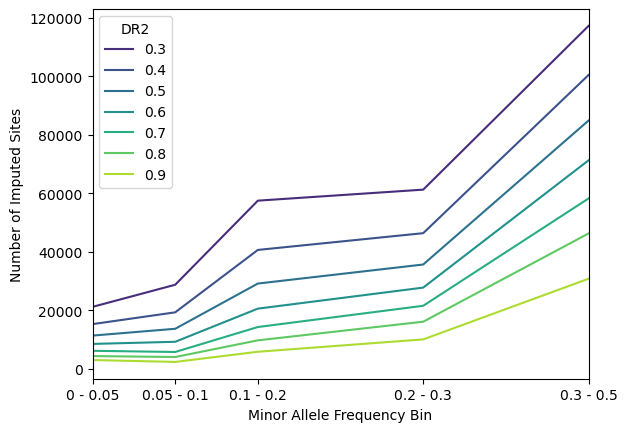

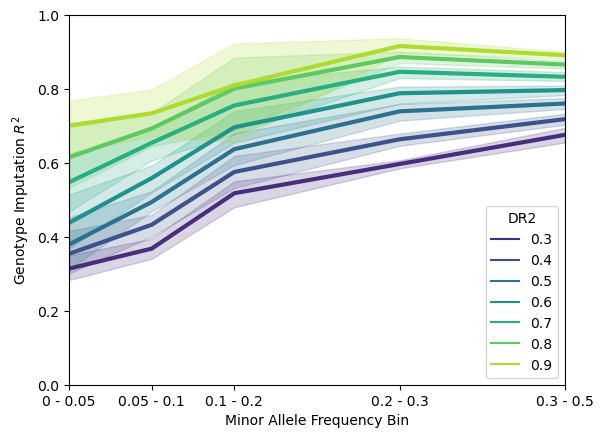

In [82]:
plt.figure()
g = sns.lineplot(data = imputed_concord.drop_duplicates(["DR2", "BIN"]), x = "BIN", y = "N_SITES", 
                 hue = "DR2", alpha = 1, legend = True, palette = "viridis")
plt.xlim(0., 0.3)
plt.xlabel("Minor Allele Frequency Bin")
plt.ylabel("Number of Imputed Sites")
g.set_xticks([0, 0.05, 0.1, 0.2, 0.3])
g.set_xticklabels(["0 - 0.05", "0.05 - 0.1", "0.1 - 0.2", "0.2 - 0.3", "0.3 - 0.5"])
plt.figure()
g = sns.lineplot(data = imputed_concord, x = "BIN", y = 1, 
                 hue = "DR2", alpha = 0.25, legend = False, palette = "viridis")
g = sns.lineplot(data = aggregated, x = "BIN", y = 1, 
                 hue = "DR2", alpha = 1, lw = 3, palette = "viridis")
plt.xlim(0., 0.3)
plt.ylim(0,1)
plt.xlabel("Minor Allele Frequency Bin")
plt.ylabel("Genotype Imputation $R^2$")
g.set_xticks([0, 0.05, 0.1, 0.2, 0.3])
g.set_xticklabels(["0 - 0.05", "0.05 - 0.1", "0.1 - 0.2", "0.2 - 0.3", "0.3 - 0.5"])
#plt.savefig("../microarray_impute.pdf", dpi = 300)

Test with Beagle 5 imputation:

In [83]:
for chrs in ['Apal_hic_scaffold_10', 'Apal_hic_scaffold_35', 'Apal_hic_scaffold_2', 
             'Apal_hic_scaffold_30', 'Apal_hic_scaffold_20', 'Apal_hic_scaffold_17', 
             'Apal_hic_scaffold_4', 'Apal_hic_scaffold_31', 'Apal_hic_scaffold_5', 
             'Apal_hic_scaffold_15', 'Apal_hic_scaffold_6', 'Apal_hic_scaffold_1', 
             'Apal_hic_scaffold_21', 'Apal_hic_scaffold_11']:
    vcf = pd.read_csv("../calls/eval_lifted_input_" + chrs + "_imputed.vcf.gz", 
                      sep = "\t", header = None, comment = "#", compression = "gzip")
    vcf.columns =  [0,1,2,3,4,5,6,7,8] + [i + "_imp" for i in sampmap["#IID"].tolist()]

In [84]:
imputed = pd.DataFrame()
for chrs in ['Apal_hic_scaffold_10']:
    vcf = pd.read_csv("../calls/eval_lifted_input_" + chrs + "_imputed.vcf.gz", 
                      sep = "\t", header = None, comment = "#", compression = "gzip")
    vcf.columns =  [0,1,2,3,4,5,6,7,8] + [i + "_imp" for i in sampmap["#IID"].tolist()]
    vcf["DR2"] = vcf[7].str.split(";", expand = True)[0].str.replace("DR2=", "").astype(float)
    confident = vcf.copy().reset_index(drop=True)
    for samp in header:
        confident[samp] = confident[samp].str.split(":", expand = True)[1]
    imputed = pd.concat([imputed, confident]).reset_index(drop=True)

In [85]:
imputed = pd.DataFrame()
for chrs in ['Apal_hic_scaffold_10', 'Apal_hic_scaffold_35', 'Apal_hic_scaffold_2', 
             'Apal_hic_scaffold_30', 'Apal_hic_scaffold_20', 'Apal_hic_scaffold_17', 
             'Apal_hic_scaffold_4', 'Apal_hic_scaffold_31', 'Apal_hic_scaffold_5', 
             'Apal_hic_scaffold_15', 'Apal_hic_scaffold_6', 'Apal_hic_scaffold_1', 
             'Apal_hic_scaffold_21', 'Apal_hic_scaffold_11']:
    vcf = pd.read_csv("../calls/eval_lifted_input_" + chrs + "_imputed.vcf.gz", 
                      sep = "\t", header = None, comment = "#", compression = "gzip")
    vcf.columns =  [0,1,2,3,4,5,6,7,8] + [i + "_imp" for i in sampmap["#IID"].tolist()]
    vcf["DR2"] = vcf[7].str.split(";", expand = True)[0].str.replace("DR2=", "").astype(float)
    confident = vcf.copy().reset_index(drop=True)
    for samp in header:
        confident[samp] = confident[samp].str.split(":", expand = True)[0].replace(scoring)
    imputed = pd.concat([imputed, confident]).reset_index(drop=True)

imputed.columns = [0,1,2,3,4,5,6,"IMPUTEFIELD",8] + [i + "_imp" for i in sampmap["#IID"].tolist()] + ["DR2"]
imputed = imputed.merge(ref, how = "left", on = [0,1,3,4]).reset_index(drop=True)
imputed = imputed.merge(mafmeta[[0,1,3,4,"MAF"]], how = "left", on = [0,1,3,4])
imputed["MAF"] = imputed["MAF"].str.split(";", expand = True)[3].str.replace("MAF=", "").astype(float)
imputed = imputed[imputed["IMPUTEFIELD"].str.contains("IMP")].reset_index(drop=True)
imputed["DR2"] = imputed["DR2"].astype(float)
imputed["MAC"] = imputed["MAF"] * (99 * 2)
imputed["MAC"] = imputed["MAC"].round(0)

In [86]:
imputed_concord = pd.DataFrame()
for i in range(len(bins)):
    for DR2 in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        samps = refheader
        rsq = []
        for name in refheader:
            try:
                rsq = rsq + [rsquared(imputed[name + "_imp"][imputed[name] != "./."][imputed["DR2"] > DR2][imputed["MAF"] > bins[i][0]][imputed["MAF"] <= bins[i][1]].astype(int), 
                                  imputed[name][imputed[name] != "./."][imputed["DR2"] > DR2][imputed["MAF"] > bins[i][0]][imputed["MAF"] <= bins[i][1]].astype(int))]
            except:
                pass
        tmp = pd.DataFrame(data = [refheader, rsq]).T
        tmp["BIN"] = bins[i][0]
        tmp["DR2"] = DR2
        tmp["N_SITES"] = len(imputed[imputed["DR2"] > DR2][imputed["MAF"] > bins[i][0]][imputed["MAF"] <= bins[i][1]])
        imputed_concord = pd.concat([imputed_concord, tmp]).reset_index(drop=True)

/tmp/ipykernel_2621044/4046793829.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp["N_SITES"] = len(imputed[imputed["DR2"] > DR2][imputed["MAF"] > bins[i][0]][imputed["MAF"] <= bins[i][1]])
/tmp/ipykernel_2621044/4046793829.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp["N_SITES"] = len(imputed[imputed["DR2"] > DR2][imputed["MAF"] > bins[i][0]][imputed["MAF"] <= bins[i][1]])
/tmp/ipykernel_2621044/4046793829.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp["N_SITES"] = len(imputed[imputed["DR2"] > DR2][imputed["MAF"] > bins[i][0]][imputed["MAF"] <= bins[i][1]])
/tmp/ipykernel_2621044/4046793829.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp["N_SITES"] = len(imputed[imputed["DR2"] > DR2][imputed["MAF"] > bins[i][0]][imputed["MAF"] <= bins[i][1]])
/tmp/ipykernel_2621044/4046793829.py:15: UserWarning: Boolean Series key will be

In [87]:
imputed_concord = imputed_concord[imputed_concord[1].notna()].reset_index(drop=True)
imputed_concord[1] = imputed_concord[1].astype(float)
imputed_concord["DR2"] = imputed_concord["DR2"].astype(str)
aggregated = imputed_concord.groupby(['BIN', "DR2"], as_index=False).mean()

/tmp/ipykernel_2621044/3507530645.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated = imputed_concord.groupby(['BIN', "DR2"], as_index=False).mean()


In [91]:
for DR2 in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    print(DR2, 
          len(imputed[imputed["DR2"] > DR2][imputed["MAF"] > 0.05]),
          len(imputed[imputed["DR2"] > DR2][imputed["MAF"] > 0.1]), 
          len(imputed[imputed["DR2"] > DR2]))

/tmp/ipykernel_2621044/3658445626.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(imputed[imputed["DR2"] > DR2][imputed["MAF"] > 0.05]),
/tmp/ipykernel_2621044/3658445626.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(imputed[imputed["DR2"] > DR2][imputed["MAF"] > 0.1]),


0.3 318705 280429 347252
0.4 249839 222189 271186
0.5 194562 175194 210470
0.6 150835 137691 162917
0.7 116188 107876 124815
0.8 87182 82157 93311
0.9 57191 54170 61288


In [89]:
for i in [[0.1, 0.5]]:
    for DR2 in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        samps = refheader
        rsq = []
        for name in refheader:
            try:
                rsq = rsq + [rsquared(imputed[name + "_imp"][imputed[name] != "./."][imputed["DR2"] > DR2][imputed["MAF"] > i[0]][imputed["MAF"] <= i[1]].astype(int), 
                                  imputed[name][imputed[name] != "./."][imputed["DR2"] > DR2][imputed["MAF"] > i[0]][imputed["MAF"] <= i[1]].astype(int))]
            except:
                pass
        print(DR2, np.mean(rsq))

0.3 0.576304438036311
0.4 0.6308942907959145
0.5 0.6893232491869353
0.6 0.7559440967344048
0.7 0.8180540886129082
0.8 0.8613838036774237
0.9 0.8920886403828069


[Text(0.0, 0, '0 - 0.05'),
 Text(0.05, 0, '0.05 - 0.1'),
 Text(0.1, 0, '0.1 - 0.2'),
 Text(0.2, 0, '0.2 - 0.3'),
 Text(0.3, 0, '0.3 - 0.5')]

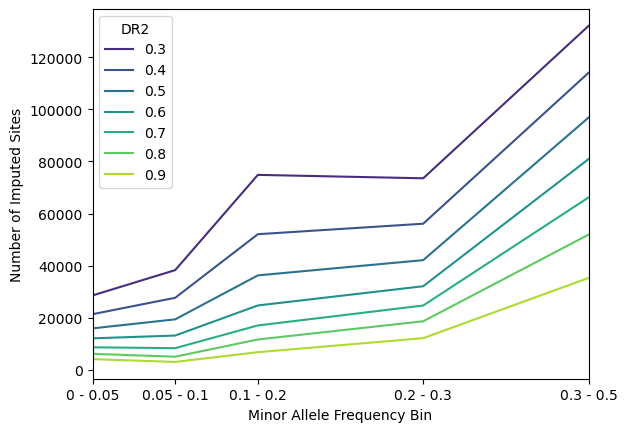

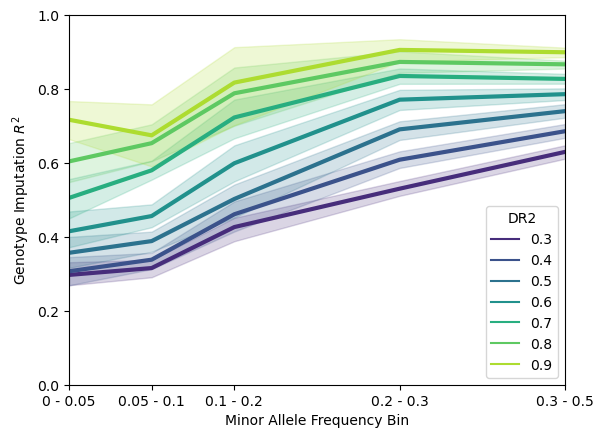

In [90]:
plt.figure()
g = sns.lineplot(data = imputed_concord.drop_duplicates(["DR2", "BIN"]), x = "BIN", y = "N_SITES", 
                 hue = "DR2", alpha = 1, legend = True, palette = "viridis")
plt.xlim(0., 0.3)
plt.xlabel("Minor Allele Frequency Bin")
plt.ylabel("Number of Imputed Sites")
g.set_xticks([0, 0.05, 0.1, 0.2, 0.3])
g.set_xticklabels(["0 - 0.05", "0.05 - 0.1", "0.1 - 0.2", "0.2 - 0.3", "0.3 - 0.5"])
plt.figure()
g = sns.lineplot(data = imputed_concord, x = "BIN", y = 1, 
                 hue = "DR2", alpha = 0.25, legend = False, palette = "viridis")
g = sns.lineplot(data = aggregated, x = "BIN", y = 1, 
                 hue = "DR2", alpha = 1, lw = 3, palette = "viridis")
plt.xlim(0., 0.3)
plt.ylim(0,1)
plt.xlabel("Minor Allele Frequency Bin")
plt.ylabel("Genotype Imputation $R^2$")
g.set_xticks([0, 0.05, 0.1, 0.2, 0.3])
g.set_xticklabels(["0 - 0.05", "0.05 - 0.1", "0.1 - 0.2", "0.2 - 0.3", "0.3 - 0.5"])
#plt.savefig("../microarray_impute.pdf", dpi = 300)

We can see here that Beagle 5 has much higher imputation accuracy. Many more sites have concordance with the "truth" set. At the lower MAF end, it looks like Beagle 4 performs better, but many of these sites will be disregarded in the GWAS anyway. 